# Prepare raw data for training

Data preparation process includes: 

0. (Before conversion) Place raw data in `data/raw`

1. Copy raw data to `data/interim` and split data into training, testing, and validation sets

2. Downsize data to (256x256) and save to data/procesed

## Step 0: Place raw data in `data/raw`

The raw image data from Zahra consists of identically named '.tif' files of the OCT scans and the labeled ground truth masks. This image data was organized in the following:
```
   └── raw
      └── OCT_scans
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```

## Step 1.1: Copy data to `data/interim`

Raw data should never be modified. Hence it is copied into `data/interim`. This is the data that will be modified.

In [11]:
# Define raw data directory and interim directory
raw_dir = "../data/raw/OCT_scans_new_20230419"
interim_dir = "../data/interim/OCT_scans_new_20230419"

In [ ]:
import shutil
copy_if_dir_exists = True
# Copy directory to interim dir
shutil.copytree(src=raw_dir, dst=interim_dir, dirs_exist_ok=copy_if_dir_exists)

Validate the images and masks are expected. Images should be an 8-bit image and masks should be binary labeled as 0 (background) and 1 (foreground)

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import tifffile
import numpy as np
import os
# Get all image names
img_dir = f"{interim_dir}/images"
mask_dir = f"{interim_dir}/skull_mask"
img_names = os.listdir(img_dir)
# Randomly select a single image name
img_name = np.random.choice(img_names)
print(f"NAME:\t{img_name}")

NAME:	unet (148).tif


IMAGE STATS:
shape:	(512, 512)
dtype:	uint16
min:	0
max:	62358


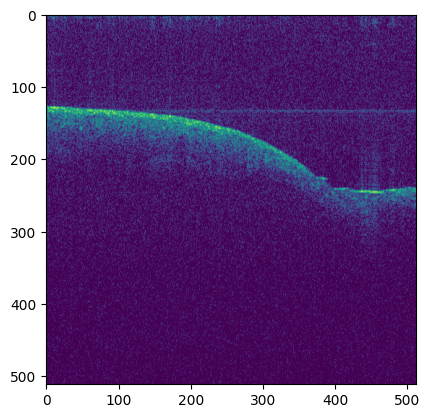

In [41]:
# Show image statistics and image
img_path = f"{img_dir}/{img_name}"
img = tifffile.imread(img_path)
print(f"IMAGE STATS:\nshape:\t{img.shape}\ndtype:\t{img.dtype}\nmin:\t{np.amin(img)}\nmax:\t{np.amax(img)}")
plt.imshow(img)

MASK STATS:
shape:	(512, 512)
dtype:	bool
min:	False
max:	True
unique:	[False  True]


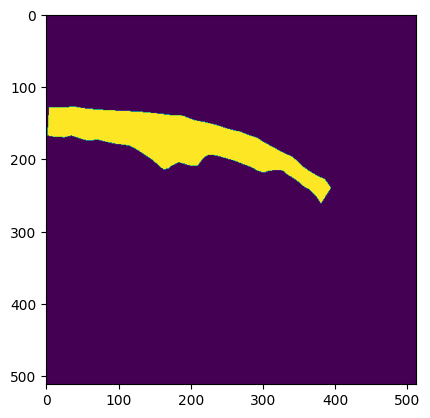

In [42]:
# Show mask statistics and image
mask_path = f"{mask_dir}/{img_name}"
mask = tifffile.imread(mask_path)
print(f"MASK STATS:\nshape:\t{mask.shape}\ndtype:\t{mask.dtype}\nmin:\t{np.amin(mask)}\nmax:\t{np.amax(mask)}\nunique:\t{np.unique(mask)}")
plt.imshow(mask)

## Step 1.2: Converting images to desired `dtype` and masks to categorically labeled `int` images.



In [43]:
def to_(img:np.ndarray, dtype, scaling:float,  offset:float = 0):
    """
    Return image converted to uint8
    
    Pixel-wise intensity formual: I = I*scaling + offset.
    Casts to dtype before return

    Args:
        img (np.ndarray): Image to convert
        dtype: dtype class to convert to
        scaling (float): Scaling in pixel-wise transform formula
        offset (float): Offset in pixel-wise transform formula
    """
    flt = img.astype(float)
    flt = flt*scaling + offset
    return flt.astype(dtype)

# Converting images to 0-1 float
scaling = (2**8 -1)/(2**16 - 1)
for img_name in os.listdir(img_dir):
    img_path = f"{img_dir}/{img_name}"
    img = tifffile.imread(img_path)
    # Linearly downscale intensities to 8-bit and save image
    if img.dtype == 'uint16':
        print(f"Converting {img_name} image")
        img = to_(img, np.uint8, scaling)
        tifffile.imwrite(img_path, img)

# Convert images
scaling = 1
for mask_name in os.listdir(mask_dir):
    mask_path = f"{mask_dir}/{mask_name}"
    mask = tifffile.imread(mask_path)
    # Linearly downscale intensities to 8-bit and save image
    print(f"Converting {mask_name} mask")
    mask = to_(mask, np.uint8, scaling)
    tifffile.imwrite(mask_path, mask)

Converting unet (1).tif image
Converting unet (10).tif image
Converting unet (100).tif image
Converting unet (102).tif image
Converting unet (103).tif image
Converting unet (104).tif image
Converting unet (105).tif image
Converting unet (106).tif image
Converting unet (107).tif image
Converting unet (108).tif image
Converting unet (109).tif image
Converting unet (11).tif image
Converting unet (110).tif image
Converting unet (111).tif image
Converting unet (112).tif image
Converting unet (113).tif image
Converting unet (114).tif image
Converting unet (115).tif image
Converting unet (116).tif image
Converting unet (117).tif image
Converting unet (118).tif image
Converting unet (119).tif image
Converting unet (12).tif image
Converting unet (120).tif image
Converting unet (121).tif image
Converting unet (122).tif image
Converting unet (123).tif image
Converting unet (124).tif image
Converting unet (125).tif image
Converting unet (126).tif image
Converting unet (127).tif image
Converting un

Re-validate the images are as expected format.

NAME:	unet (127).tif
IMAGE STATS:
shape:	(512, 512)
dtype:	uint8
min:	0
max:	254


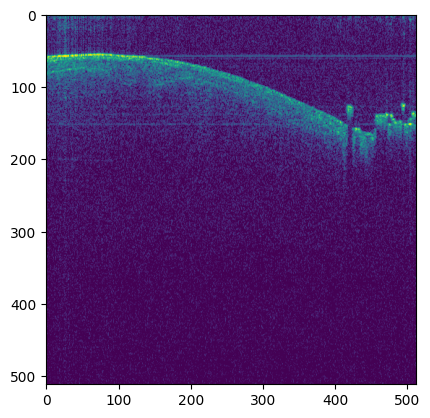

In [48]:
img_names = os.listdir(img_dir)
# Randomly select a single image name
img_name = np.random.choice(img_names)
print(f"NAME:\t{img_name}")
# Show image statistics and image
img_path = f"{img_dir}/{img_name}"
img = tifffile.imread(img_path)
print(f"IMAGE STATS:\nshape:\t{img.shape}\ndtype:\t{img.dtype}\nmin:\t{np.amin(img)}\nmax:\t{np.amax(img)}")
plt.imshow(img)

MASK STATS:
shape:	(512, 512)
dtype:	uint8
min:	0
max:	1
unique:	[0 1]


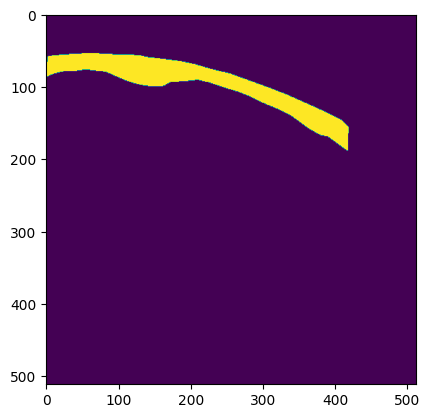

In [49]:
# Show mask statistics and image
mask_path = f"{mask_dir}/{img_name}"
mask = tifffile.imread(mask_path)
print(f"MASK STATS:\nshape:\t{mask.shape}\ndtype:\t{mask.dtype}\nmin:\t{np.amin(mask)}\nmax:\t{np.amax(mask)}\nunique:\t{np.unique(mask)}")
plt.imshow(mask)

## Step 1.3: Split data into training, testing, and validation sets

Following steps assume you have an data directory as shown:

```
   └── interim
      └── OCT_scans
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```

Where each "img" has the same filename between images<->masks.

After splitting, you will have the following data structure:
```
   └── interim
      └── OCT_scans
         ├── split
         │  ├── train
         │  │  ├── images
         │  │  └── masks
         │  ├── val
         │  │  ├── images
         │  │  └── masks
         │  └── test
         │     ├── images
         │     └── masks
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```


In [12]:
%load_ext autoreload
%autoreload 2
from src.data.splitting import single_dir_split
single_dir_split(data_dir=interim_dir, img_dir_name='images', mask_dir_name='masks', split_vals=(70,20,10), ext='.tif')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 129 image-mask pairs from 129 images and 129 masks
copying data from 90 training instances
copying data from 26 validation instances
copying data from 13 testing instances


## Step 1.4: Crop images and resize

Finally, take each image and crop it to a smaller size, resize it even smaller, and then save it. We downsize it drastically to reduce deep learning model overhead.

In [13]:
%load_ext autoreload
%autoreload 2
from src.data.cropping import crop_and_resize_dir
import os
SIZE = 128
input_dir = f"{interim_dir}/split"
data_basename = os.path.basename(raw_dir)
output_dir = f"../data/processed/{data_basename}_{SIZE}x{SIZE}"
crop_and_resize_dir(input_dir=input_dir,output_dir=output_dir, ncrops=1, size=(SIZE, SIZE), ext=".tif")

INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (1).tif
INFO: Created directory: ../data/processed/OCT_scans_new_20230419_128x128\test\images
INFO: Used interpolation:AREA
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (10).tif
INFO: Used interpolation:AREA
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (136).tif
INFO: Used interpolation:AREA
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (140).tif
INFO: Used interpolation:AREA
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (155).tif
INFO: Used interpolation:AREA
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (158).tif
INFO: Used interpolation:AREA
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\images/unet (164).tif
INFO: Used interpolation:AREA
INFO: C

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO: Created directory: ../data/processed/OCT_scans_new_20230419_128x128\test\masks
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (10).tif
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (136).tif
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (140).tif
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (155).tif
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (158).tif
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (164).tif
INFO: Used interpolation:NEAREST
INFO: Cropping and resizing ../data/interim/OCT_scans_new_20230419/split\test\masks/unet (1